#**Project: Music Recommendation System**

--------------
## **Context**
--------------

With the advent of technology, societies have become more efficient with their lives. At the same time, however, individual human lives have also become more fast-paced and distracted, leaving little time to explore artistic pursuits. Also, technology has made significant advancements in the ability to coexist with art and general entertainment. It has in fact made it easier for humans with a shortage of time to find and consume good content.
Almost every internet-based company's revenue relies on the time consumers spend on its platform. These companies need to be able to figure out what kind of content is needed in order to increase customer time spent and make their experience better. Therefore, one of the key challenges for these companies is figuring out what kind of content their customers are most likely to consume.
Spotify is one such audio content provider with a huge market base across the world. With the ever-increasing volume of songs becoming available on the Internet, searching for songs of interest has become a tedious task in itself. However, Spotify has grown significantly in the market because of its ability to recommend the ‘best’ next song to each and every customer based on a huge preference database gathered over time - millions of customers and billions of songs. This is done by using smart recommendation systems that can recommend songs based on users’ likes/dislikes.

----------------
## **Objective**
----------------

Build a recommendation system to propose the top 10 songs for a user based on the likelihood of listening to those songs.

-----------------------------
## **Data Dictionary** 
-----------------------------

The core dataset is the Taste Profile Subset released by The Echo Nest as part of the Million Song Dataset. There are two files in this dataset. One contains the details about the song id, titles, release, artist name, and the year of release. The second file contains the user id, song id, and the play count of users.

song_data
- **song_id**: A unique id given to every song
- **title**: Title of the song
- **Release**: Name of the released album
- **Artist_name**: Name of the artist
- **year**: Year of release

count_data
- **user _id**: A unique id given to the user
- **song_id**: A unique id given to the song
- **play_count**: Number of times the song was played

In [ ]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Install Surprise Library

In [ ]:
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 41.9 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633993 sha256=37efe0d43d88d4f028bb82d522c0703eda163368caff87512050559d68a5b22c
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


###Import Required Libraries

In [ ]:
import warnings                                 # Used to ignore the warning given as output of the code
warnings.filterwarnings('ignore')

import numpy as np                              # Basic libraries of python for numeric and dataframe computations
import pandas as pd

import matplotlib.pyplot as plt                 # Basic library for data visualization
import seaborn as sns                           # Slightly advanced library for data visualization

from collections import defaultdict             # A dictionary output that does not raise a key error

from sklearn.metrics import mean_squared_error  # A performance metrics in sklearn

# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

#**Milestone 1**
#Load the data

In [ ]:
count_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Capstone Project/count_data.csv')
song_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Capstone Project/song_data.csv')

In [ ]:
count_df.head()

,Unnamed: 0,user_id,song_id,play_count
0,0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
2,2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1
3,3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1
4,4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1


In [ ]:
count_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 4 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   Unnamed: 0  int64 
 1   user_id     object
 2   song_id     object
 3   play_count  int64 
dtypes: int64(2), object(2)
memory usage: 61.0+ MB


In [ ]:
count_df.isnull().sum()

Unnamed: 0    0
user_id       0
song_id       0
play_count    0
dtype: int64

In [ ]:
count_df.nunique()

Unnamed: 0    2000000
user_id         76353
song_id         10000
play_count        295
dtype: int64

- This dataset has 2 million rows and 4 columns
- Columns unnamed and playcount are integers
- columns user_id and song_id are object
- drop unnamed
- consider one-hot encoding for user-id and song_id
- No null values
- 76,353 unique users, 10,000 unique songs, and 295 unique play_counts

In [ ]:
song_df.head(
)

,song_id,title,release,artist_name,year
0,SOQMMHC12AB0180CB8,Silent Night,Monster Ballads X-Mas,Faster Pussy cat,2003
1,SOVFVAK12A8C1350D9,Tanssi vaan,Karkuteillä,Karkkiautomaatti,1995
2,SOGTUKN12AB017F4F1,No One Could Ever,Butter,Hudson Mohawke,2006
3,SOBNYVR12A8C13558C,Si Vos Querés,De Culo,Yerba Brava,2003
4,SOHSBXH12A8C13B0DF,Tangle Of Aspens,Rene Ablaze Presents Winter Sessions,Der Mystic,0


In [ ]:
song_df.isnull().sum()

song_id         0
title          15
release         5
artist_name     0
year            0
dtype: int64

In [ ]:
song_df.nunique()

song_id        999056
title          702428
release        149288
artist_name     72665
year               90
dtype: int64

- This dataset has 1 million rows and 5 columns
- All columns but Year are object data types; however, some years are marked as 0 so will drop that column for now since it will only had confusion
- Title and Release both have a few null values but depending on our cutoff for rating, these might become obsolete
- 999,056 unique songs(ids); 702,428 unique titles; 149,288 unique albums; 72,665 unique artists; and 90 unique years represented in dataset. 


Looking at this dataset, I will:
1. Drop unnamed column
2. Merge count dataset with 'title' column in song dataset
3. Use LabelEncoder to encode song_ids and user_ids

##Data Pre-Processing

In [ ]:
#Drop Unnamed column in count_df
count_df = count_df.drop('Unnamed: 0', axis = 1)

Year '0' encompasses almost 25% of the 2,000,000 row dataset. I want to see if np.nan will provide more insight by replacing the 0 with NaN

In [ ]:
song_df['year'].replace(0,np.nan, inplace= True)

In [ ]:
song_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 5 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   song_id      1000000 non-null  object 
 1   title        999985 non-null   object 
 2   release      999995 non-null   object 
 3   artist_name  1000000 non-null  object 
 4   year         515576 non-null   float64
dtypes: float64(1), object(4)
memory usage: 38.1+ MB


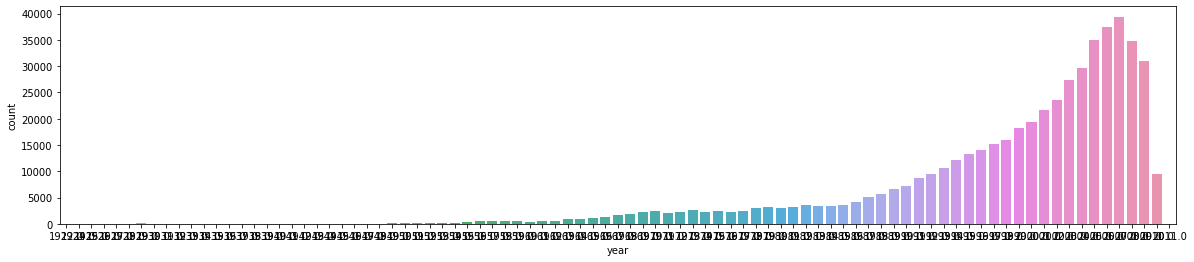

In [ ]:
plt.figure(figsize = (20,4))
sns.countplot(data = song_df, x = 'year')
plt.show()

Using replace/np.nan for any 0 in the Year column helped plot the distribution of songs int he dataset and their release years. 
As we can see, there are more songs from the 2000s represented in the dataset than from the 19000s. 

###Merge Datasets

In [ ]:
#Merge count_df with song_df
count_with_title = pd.merge(count_df, song_df, on = 'song_id', how = 'left')
count_with_title

,user_id,song_id,play_count,title,release,artist_name,year
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,NaN
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976.0
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Graduation,Kanye West,2007.0
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Graduation,Kanye West,2007.0
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,In Between Dreams,Jack Johnson,2005.0
...,...,...,...,...,...,...,...
2086941,d8bfd4ec88f0f3773a9e022e3c1a0f1d3b7b6a92,SOJEYPO12AAA8C6B0E,2,Ignorance (Album Version),Ignorance,Paramore,NaN
2086942,d8bfd4ec88f0f3773a9e022e3c1a0f1d3b7b6a92,SOJJYDE12AF729FC16,4,Two Is Better Than One,Love Drunk,Boys Like Girls featuring Taylor Swift,2009.0
2086943,d8bfd4ec88f0f3773a9e022e3c1a0f1d3b7b6a92,SOJKQSF12A6D4F5EE9,3,What I've Done (Album Version),What I've Done,Linkin Park,2007.0
2086944,d8bfd4ec88f0f3773a9e022e3c1a0f1d3b7b6a92,SOJUXGA12AC961885C,1,Up,My Worlds,Justin Bieber,2010.0


###Encode Encrypted Data

In [ ]:
#Use LabelEncoder to simplify user ids and song ids
from sklearn.preprocessing import LabelEncoder
data = count_with_title[['user_id', 'song_id']].apply(LabelEncoder().fit_transform)
data['play_count'] = count_with_title['play_count']
data['title'] = count_with_title['title']
data['artist_name'] = count_with_title['artist_name']
data['year'] = count_with_title['year']

data.head()

,user_id,song_id,play_count,title,artist_name,year
0,54961,153,1,The Cove,Jack Johnson,NaN
1,54961,413,2,Entre Dos Aguas,Paco De Lucia,1976.0
2,54961,736,1,Stronger,Kanye West,2007.0
3,54961,736,1,Stronger,Kanye West,2007.0
4,54961,750,1,Constellations,Jack Johnson,2005.0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2086946 entries, 0 to 2086945
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   user_id      int64  
 1   song_id      int64  
 2   play_count   int64  
 3   title        object 
 4   artist_name  object 
 5   year         float64
dtypes: float64(1), int64(3), object(2)
memory usage: 111.5+ MB


With the merge, we gained an additional 86,946 rows. Let's check if there are duplicates. If so, use drop_duplicates().

In [ ]:
data.duplicated().sum()

70827

In [ ]:
data.drop_duplicates(subset=['user_id','song_id'], keep='first', inplace=True, ignore_index= True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   user_id      int64  
 1   song_id      int64  
 2   play_count   int64  
 3   title        object 
 4   artist_name  object 
 5   year         float64
dtypes: float64(1), int64(3), object(2)
memory usage: 91.6+ MB


In [ ]:
df = data.copy()
df2 = data.copy()
df3 = data.copy()

In this first section, I:
- observed the datatypes, null values, and unique values in each imported dataset
- dropped columns that did not offer much insight
- merged the datasets on song_id into one data set and dropped duplicates
- encoded the encryped user_id and song_id for a simplified dataframe
- made copies of this final and simplified dataset just in case

#**Exploratory Data Analysis**

In this section, I will explore the information provided by the data that will offer the most insight. 

In [ ]:
data['play_count'].describe()

count    2.000000e+06
mean     3.045485e+00
std      6.579720e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      3.000000e+00
max      2.213000e+03
Name: play_count, dtype: float64

- This summary statistic shows that 75% of observations (aka user + song combo) have a playcount of 3 or less, with a mean of 3 and a median of 1. 
- This does not say much about the popularity of the song itself but rather that most users don't listen to a particular song more than 3 times. 
- The upper quartile (between 3rd quartile and max), however, seems to be where A LOT of outliers live since the data set has 295 unique playcounts and a max of 2213 counts for one user+song combo
- With this in mind, perhaps drop any rows that have more than 3 play counts (or 10 for wiggle room)/have a cutoff when developing models or just drop users have have listened to less than a certain amount of songs and vice versa


In [ ]:
data['play_count'].value_counts()

1      1138433
2       313043
3       142933
5        93136
4        82569
        ...   
255          1
302          1
330          1
431          1
260          1
Name: play_count, Length: 295, dtype: int64

- This value_counts method corroborates the observations noted above, with the majority of observations (user + song combo) having a play count below 3 and 4 to 2213 being the outliers

Which song has the most play counts?

In [ ]:
data.groupby('song_id').sum()['play_count'].sort_values(ascending = False)

song_id
614     54136
317     49253
7416    41418
1664    31153
2220    31036
        ...  
164        76
7251       75
1771       73
5402       73
3971       71
Name: play_count, Length: 10000, dtype: int64

The most a song has been listened to is 54,136 times and the least is 71 times.

In [ ]:
data.groupby('song_id').sum()['play_count'].sort_values(ascending = False).describe()

count    10000.000000
mean       609.096900
std       1401.268442
min         71.000000
25%        221.000000
50%        336.000000
75%        587.000000
max      54136.000000
Name: play_count, dtype: float64

- The above observations show each song's total playcount
- Summary statistics:
1. The average song is listened to a total of 609 times, however, looking at the data, the mean is sensitive to outliers
2. The median playcount of songs in this data set is 336 times.
3. The majority of the songs in this dataset were listened to less than 587 times. This suggests that the 4th quartile (between 75% and max value) holds A LOT of outliers, with the most popular song in the data set - You're The One - being listened to over 54,000+ times. 

Which song has been listened to by the most users?

In [ ]:
data.groupby('song_id').count()['user_id'].sort_values(ascending = False)

song_id
2220    8277
317     7032
352     6949
614     6412
7416    6145
        ... 
8747      51
4492      51
622       50
9638      48
2666      48
Name: user_id, Length: 10000, dtype: int64

Which user has listened to the most songs?

In [ ]:
data.groupby('user_id').count()['song_id'].sort_values(ascending = False)

user_id
32542    711
75144    643
23297    556
10807    540
7834     533
        ... 
4929       1
40445      1
19698      1
40417      1
56932      1
Name: song_id, Length: 76353, dtype: int64

- The song with the lowest number of users/listeners is song_id = 2666 and highest is song_id = 2220. However, the same cannot be said when considering the total playcount for each song. 
- The user that has listened to the most unique number of songs is user_id = 32542 and many users have only listened to one song, however, that does not necessarily mean they have only listened to the song once. 
- However, looking at the dataset, it looks like it makes most sense to reduce the dataset by removing users that have listened below a certain number of songs and removing songs that have only been listened by a small number of users (especially since there are over 75,000 users and 10,000 songs). This is because we are more likely to find similarities between users that have listened to a wide range of songs and items that have been listened to by a large number of listeners. Playcount, in itself, will not provide much insight into the patterns to create an effective recommendation system.

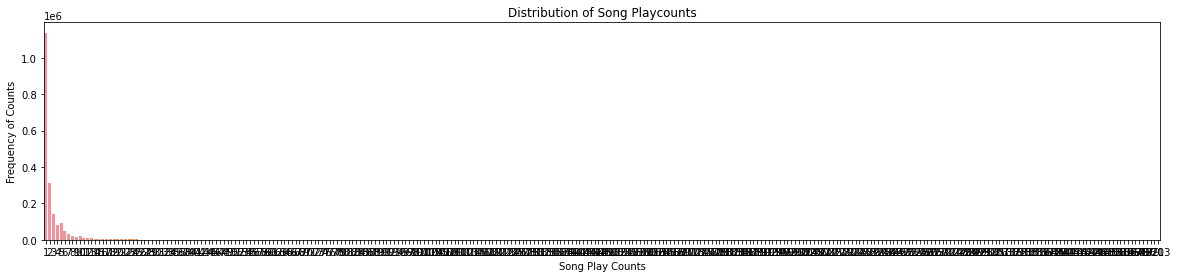

In [ ]:
plt.figure(figsize = (20,4))
sns.countplot(data = data, x = 'play_count')
plt.title('Distribution of Song Playcounts')
plt.xlabel('Song Play Counts')
plt.ylabel('Frequency of Counts')
plt.show()

This plot shows that after about 10 play_counts, the rest are just outliers. So, when dropping rows, consider dropping rows where a user has listened to a song over 10 times.

##**Data Preparation**

As this dataset is quite large and has 2 million observations, it is not going be computationally efficient to build a model using this. Moreover, there are many users who have only listened to a few songs and also there are songs listened by few users. Hence we can reduce the dataset to a more manageable amount of observations by considering certain logical assumptions, such as:
- removing users that have listened to less than 50 songs don't have much insight into the songs available or not very interested in music. Test other values if dataset is not significantly reduced
- removing songs that do not have at least 100 listeners won't be listened by many more thus do not offer much insight. Test other values if dataset is not significantly reduced
- removing songs that have users have listened to over 10 times

Let's see how this helps reduce the dataset for now. 

###Drop users who listen to less than 100 songs

In [ ]:
users = data.user_id
song_count = dict()
for user in users:
  if user in song_count:
    song_count[user] += 1
  else:
    song_count[user] = 1

In [ ]:
song_count_cutoff = 100

remove_users = []

for user, num_songs in song_count.items():
  if num_songs < song_count_cutoff:
    remove_users.append(user)
data = data.loc[~data.user_id.isin(remove_users)]

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 373273 entries, 196 to 1999769
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   user_id      373273 non-null  int64  
 1   song_id      373273 non-null  int64  
 2   play_count   373273 non-null  int64  
 3   title        373273 non-null  object 
 4   artist_name  373273 non-null  object 
 5   year         310993 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 19.9+ MB


In [ ]:
data.nunique()

user_id        2466
song_id        9996
play_count      151
title          9563
artist_name    3372
year             57
dtype: int64

This technique reduced the dataset by over half and users by ~85%

In [ ]:
songs = data.song_id
user_count = dict()

for song in songs:
  if song in user_count:
    user_count[song] += 1
  else:
    user_count[song] = 1

In [ ]:
user_count_cutoff = 100
remove_songs = []

for song, num_users in user_count.items():
  if num_users < user_count_cutoff:
    remove_songs.append(song)
data = data.loc[~data.song_id.isin(remove_songs)]

In [ ]:
data.drop(data.index[data['play_count'] > 10], inplace = True )

In [ ]:
df_final = data

In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112921 entries, 200 to 1999765
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   user_id      112921 non-null  int64  
 1   song_id      112921 non-null  int64  
 2   play_count   112921 non-null  int64  
 3   title        112921 non-null  object 
 4   artist_name  112921 non-null  object 
 5   year         93141 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 6.0+ MB


In [ ]:
df_final.nunique()

user_id        2466
song_id         610
play_count       10
title           607
artist_name     237
year             35
dtype: int64

Observations:
Final dataset to analyze:
- 112,921 observations
- 2466 users
- 610 songs
- 10 unique playcounts
- 607 titles
- 237 artists
- 35 unique years

In Milestone 2, I will explore various recommendation system techniques such as:
- Rank Based
- Similarity Based Collaborative Filtering
- Matrix-Factorization Collaborative Filtering. 

#**Milestone 2**: Building Recommendation Systems

## **Model 1: Create Rank-Based Recommendation System**

- Rank-based recommendation systems provide recommendations based on the most popular items. This kind of recommendation system is useful when we have cold start problems. Cold start refers to the issue when we get a new user into the system and the machine is not able to recommend a song to the new user, as the user did not have any historical interactions in the dataset. In those cases, we can use rank-based recommendation system to recommend a song to the new user.

- To build the rank-based recommendation system, we take average of all the play counts provided to each song and then rank them based on their average play count.

In [ ]:
df_final = data

In [ ]:
average_playcount = df_final.groupby('song_id').mean()['play_count']
play_frequency = df_final.groupby('song_id').count()['play_count']
final_count = pd.DataFrame({'avg_play_count': average_playcount, 'play_frequency': play_frequency})
final_count

,avg_play_count,play_frequency
song_id,,
21,1.782979,235
22,1.619835,121
52,2.054404,386
62,1.990385,104
93,1.779817,109
...,...,...
9939,2.195349,215
9942,3.516340,153
9960,1.736434,129


Average playcount = average number of times each user listened to the song

Play frequency = total number of times the song was listened to

In [ ]:
def top_n_songs(data, n, min_interaction=100):
    
    # Finding books with minimum number of interactions
    recommendations = final_count[final_count['play_frequency'] > min_interaction]
    
    # Sorting values w.r.t. average rating 
    recommendations = recommendations.sort_values(by = 'avg_play_count', ascending = False)

    return recommendations.index[:n]

Find Top 5 Songs with 50 Minimum Interactions

In [ ]:
top_n_songs(final_count, 5, 50)

Int64Index([7224, 6450, 8324, 614, 9942], dtype='int64', name='song_id')

Find top 10 songs with 100 minimum interactions

In [ ]:
top_n_songs(final_count, 10, 100)

Int64Index([7224, 6450, 8324, 614, 9942, 6860, 317, 5653, 8483, 1664], dtype='int64', name='song_id')

In [ ]:
recs = list(top_n_songs(final_count, 5, 50))
for i in recs:
 print(df_final.loc[df_final['song_id'] == i]['title'].unique())

['Victoria (LP Version)']
['Brave The Elements']
['The Big Gundown']
["You're The One"]
['Greece 2000']


In [ ]:
recs2 = list(top_n_songs(final_count, 10,100))
for i in recs2:
  print(df_final[df_final['song_id'] == i]['title'].unique())

['Victoria (LP Version)']
['Brave The Elements']
['The Big Gundown']
["You're The One"]
['Greece 2000']
['Mercy:The Laundromat']
['Undo']
['Transparency']
['Video Killed The Radio Star']
['Horn Concerto No. 4 in E flat K495: II. Romance (Andante cantabile)']


#**Similarity-Based Collaborative Filtering**

In this type of recommendation system, we do not need any information about the users or items. We only need user-item interaction data to build a collaborative recommendation system. For example: 
<ol>
    <li><b>Ratings</b> provided by users. For example - ratings of books on Goodreads, movie ratings on IMDB, etc.</li>
    <li><b>Likes</b> of users on different Facebook posts, likes on youtube videos</li>
    <li><b>Use/buying</b> of a product by users. For example - buying different items on e-commerce sites</li>
    <li><b>Reading</b> of articles by readers on various blogs</li>
    <li><b>Playcounts</b> of songs by users on music streaming platforms</li>
</ol>

#### **Types of Collaborative Filtering**

- Similarity/Neighborhood Based
- Matrix Factorization Based

But before we start building models, let's define some terminologies:

**Relevant item** - An item (book in this case) that is actually **rated higher than the threshold rating (here 7)** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item** - An item that's **predicted rating is higher than the threshold (here 7) is a recommended item**, if the **predicted rating is below the threshold then that book will not be recommended to the user**. 

**False Negative (FN)** - It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider** which they would like to minimize.

**False Positive (FP)** - It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider** which they would also like to minimize.

**Recall** - It is the **fraction of actually relevant items that are recommended to the user** i.e. if out of 10 relevant books, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision** - It is the **fraction of recommended items that are relevant actually** i.e. if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are the two most used performance metrics used in the assessment of recommendation systems.**

####**Precision@k and Recall@k**
**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. Value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-Score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them. 

**Some Useful Functions**

- The following function takes the **recommendation model** as input and gives the **precision@k and recall@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.

We are going to start by building a **user-user similarity-based recommendation system** using cosine similarity and using KNN to find similar users who are the nearest neighbor to the given user.



####**Model 2**: User-User Similarity Based Recommendation System




In [ ]:
# The function to calulate the RMSE, precision@k, recall@k, and F_1 score
def precision_recall_at_k(model, k = 30, threshold = 1.5):
    """Return precision and recall at k metrics for each user
       Using a threshold of 1.5 since the mean for playcount is 3
    """

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    
    # Making predictions on the test data
    predictions=model.test(testset)
    
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_playcounts in user_est_true.items():

        # Sort user playcounts by estimated value
        user_playcounts.sort(key = lambda x : x[0], reverse = True)

        # Number of relevant songs
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_playcounts)

        # Number of recommended songs in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_playcounts[ : k])

        # Number of relevant and recommended songs in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_playcounts[ : k])

        # Precision@K: Proportion of recommended songs that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant songs that are recommended
        # When n_rel is 0, Recall is undefined. We here set Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
    
    # Mean of all the predicted precisions are calculated
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)
    
    accuracy.rmse(predictions)

    # Command to print the overall precision
    print('Precision: ', precision)

    # Command to print the overall recall
    print('Recall: ', recall)
    
    # Formula to compute the F-1 score
    print('F_1 score: ', round((2 * precision * recall) / (precision + recall), 3))

Make the dataset into surprise dataset and splitting it into train and test set

In [ ]:
# Instantiating Reader scale with expected rating (playcount) 
reader = Reader(rating_scale=(1, 10))

# Loading the rating dataset
data = Dataset.load_from_df(df_final[['user_id', 'song_id', 'play_count']], reader)

# Splitting the data into train and test dataset
trainset, testset = train_test_split(data, test_size=0.4, random_state=42)

In [ ]:
sim_options = {'name': 'cosine',
               'user_based': True}

sim_user_user = KNNBasic(sim_options = sim_options, verbose = False, random_state = 1)

# Train the algorithm on the train set, and predict ratings/playcount for the test set
sim_user_user.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score 
precision_recall_at_k(sim_user_user)

RMSE: 1.7221
Precision:  0.429
Recall:  0.82
F_1 score:  0.563


**Observations:**
- This model has a very high RMSE score (1.72).
- While Precision is low (0.43), Recall is almost twice as high (0.82). Ideally, I want a balance of both, let's look at the F-1 score.
- F-1 Score is over 50% (0.56) which isn't horrible however, due to the inconsistency of all the scores in this metric, let's use GridSearch CV for hyperparamter tuning to improve scores.

First, though, let's test the predictions. 

In [ ]:
# Predicting play_count for a sample user with a listened song
sim_user_user.predict(6958, 1671, r_ui = 2, verbose = True) # Use user id 6958 and song_id 1671


user: 6958       item: 1671       r_ui = 2.00   est = 1.56   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=6958, iid=1671, r_ui=2, est=1.5567002046318954, details={'actual_k': 40, 'was_impossible': False})

In [ ]:
#Printing another list of songs listened to by user 6958
print(df_final[df_final['user_id']== 6958])

     user_id  song_id  play_count  \
200     6958      447           1   
202     6958      512           1   
203     6958      549           1   
204     6958      703           1   
205     6958      719           1   
206     6958      892           1   
209     6958     1050           5   
210     6958     1056           2   
213     6958     1480           1   
215     6958     1671           2   
216     6958     1752           1   
217     6958     1756           1   
218     6958     1787           2   
219     6958     1818           1   
221     6958     2107           1   
225     6958     2289           1   
226     6958     2304           1   
227     6958     2425           1   
228     6958     2501           1   
232     6958     2701           1   
235     6958     2898           1   
237     6958     2994           1   
239     6958     3074           1   
240     6958     3134           1   
244     6958     3491           1   
246     6958     3551           1   
2

In [ ]:
sim_user_user.predict(6958, 1056, r_ui = 2, verbose = True)

user: 6958       item: 1056       r_ui = 2.00   est = 1.58   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=6958, iid=1056, r_ui=2, est=1.5845926333966949, details={'actual_k': 40, 'was_impossible': False})

In [ ]:
sim_user_user.predict(6958, 1050, r_ui = 5, verbose = True)

user: 6958       item: 1050       r_ui = 5.00   est = 3.03   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=6958, iid=1050, r_ui=5, est=3.0313350311760785, details={'actual_k': 40, 'was_impossible': False})

In [ ]:
sim_user_user.predict(6958, 1787, r_ui = 2, verbose = True)

user: 6958       item: 1787       r_ui = 2.00   est = 2.10   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=6958, iid=1787, r_ui=2, est=2.09957570114584, details={'actual_k': 40, 'was_impossible': False})

In [ ]:
# Predicting play_count for a sample user with a song not listened by the user
sim_user_user.predict(6958, 3232, verbose = True) 

user: 6958       item: 3232       r_ui = None   est = 1.47   {'actual_k': 35, 'was_impossible': False}


Prediction(uid=6958, iid=3232, r_ui=None, est=1.4717281457727631, details={'actual_k': 35, 'was_impossible': False})

**Observations**:
- Due to the metric scores observed above, I tested the model across 4 songs user 6958 has listened to to measure overall performance by comparing the predicted playcount vs the actual playcount. To calculate this, I divided the predicted playcount by the true playcount for each song, added all four together and took the mean in order to get an average of correct guesses
- Despite the 0.56 F1 score, this model showed it was about 80% correct which shows there is room for improvement. 
- For a song a user had not listened to, it predicted a 1.47 which falls short of the threshold set earlier. 

As mentioned before, I will use GridSearch CV to tune the hyperparameters of the model to see if performance improves. 

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30], 'min_k': [3, 6, 9],
              'sim_options': {'name': ["cosine", 'pearson', "pearson_baseline"],
                              'user_based': [True], "min_support": [2, 4]}
              }

# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs = -1)
# Fitting the data
gs.fit(data) # Use entire data for GridSearch

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

1.648878559975973
{'k': 30, 'min_k': 9, 'sim_options': {'name': 'pearson_baseline', 'user_based': True, 'min_support': 2}}


In [ ]:
sim_options = {'name': 'pearson_baseline',
               'user_based': True}

sim_user_user_optimized = KNNBasic(sim_options = sim_options, k= 30, min_k = 9, verbose = False, random_state = 1)

# Train the algorithm on the train set, and predict ratings/playcount for the test set
sim_user_user_optimized.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score 
precision_recall_at_k(sim_user_user_optimized)

RMSE: 1.6540
Precision:  0.442
Recall:  0.816
F_1 score:  0.573


**Observations:**
- The optimized model still has a very high RMSE score despite lowering a little bit to 1.65.
- While Precision is still low, it rose up a little bit to 0.44, Recall remained the same at 0.82. Since I wanted a balance of both, let's look at the F-1 score.
- F-1 Score is over 50% (0.57) and showed improvement which isn't horrible but still quite low. 
After predicting playcounts and recommendations, I will continue to test different recommendation systems and see if the metric scores improve. 


In [ ]:
sim_user_user_optimized.predict(6958, 1671, r_ui = 2, verbose = True)

user: 6958       item: 1671       r_ui = 2.00   est = 1.39   {'actual_k': 18, 'was_impossible': False}


Prediction(uid=6958, iid=1671, r_ui=2, est=1.392681875259934, details={'actual_k': 18, 'was_impossible': False})

In [ ]:
sim_user_user_optimized.predict(6958, 1056, r_ui = 2, verbose = True)

user: 6958       item: 1056       r_ui = 2.00   est = 2.04   {'actual_k': 26, 'was_impossible': False}


Prediction(uid=6958, iid=1056, r_ui=2, est=2.039487513745809, details={'actual_k': 26, 'was_impossible': False})

In [ ]:
sim_user_user_optimized.predict(6958, 1050, r_ui = 5, verbose = True)

user: 6958       item: 1050       r_ui = 5.00   est = 5.22   {'actual_k': 11, 'was_impossible': False}


Prediction(uid=6958, iid=1050, r_ui=5, est=5.220743899120661, details={'actual_k': 11, 'was_impossible': False})

In [ ]:
sim_user_user_optimized.predict(6958, 1787, r_ui = 2, verbose = True)

user: 6958       item: 1787       r_ui = 2.00   est = 1.88   {'actual_k': 30, 'was_impossible': False}


Prediction(uid=6958, iid=1787, r_ui=2, est=1.879918781556753, details={'actual_k': 30, 'was_impossible': False})

In [ ]:
sim_user_user_optimized.predict(6958, 3232, verbose = True)

user: 6958       item: 3232       r_ui = None   est = 1.97   {'actual_k': 9, 'was_impossible': False}


Prediction(uid=6958, iid=3232, r_ui=None, est=1.9736456772894173, details={'actual_k': 9, 'was_impossible': False})

**Observartions**:
- Due to the metric scores observed above, I tested the model across 4 songs user 6958 has listened to to measure overall performance by comparing the predicted playcount vs the actual playcount. To calculate this, I divided the predicted playcount by the true playcount for each song, added all four together and took the mean in order to get an average of correct guesses
- Despite the 0.56 F1 score, this optimized user user model showed it was about 92.5% correct (higher than recall score) which shows that, so far, it is the more accurate model at recommending relevant songs.
- For a song the user had not listened to, it predicted a 1.97 and since the average prediction for an actual playcount was so high, this is a song the user is likely to listen to. I'll compare these numbers throughout the project for other models tested.
- The optimized user-user similarity based model is performing **much better** than its baseline model.


**5 Users Most Similar to User 0 using KNearest Neighbors**

In [ ]:
sim_user_user_optimized.get_neighbors(0, k = 5)

[1664, 930, 9, 413, 1127]

Since the original model performed better, I will use it to implement a function for the recommendation algorithm to predict the playcount of songs for a particular user. The input parameters are:
- data: A song dataset
- user_id: A user-id against which we want the recommendations
- top_n: The number of songs we want to recommend
- algo: The algorithm we want to use for predicting the play_count
- The output of the function is a set of top_n items recommended for the given - user_id based on the given algorithm

In [ ]:
def get_recommendations(data, user_id, top_n, algo):
    
    # Creating an empty list to store the recommended book ids
    recommendations = []
    
    # Creating an user item interactions matrix 
    user_item_interactions_matrix = data.pivot(index='user_id', columns='song_id', values='play_count')
    
    # Extracting those book ids which the user_id has not interacted with yet
    non_interacted_items = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()
    
    # Looping through each of the book id which user_id has not interacted with yet
    for song_id in non_interacted_items:
        
        # Predicting the ratings for those non interacted book ids by this user
        est = algo.predict(user_id, song_id).est
        
        # Appending the predicted ratings
        recommendations.append((song_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    return recommendations[:top_n] # Returning top n predicted rating items for this user

In [ ]:
recommendations = get_recommendations(df_final, 6958, 5, sim_user_user_optimized)

In [ ]:
pd.DataFrame(recommendations, columns=['song_id', 'predicted_playcount'])

,song_id,predicted_playcount
0,5653,4.941745
1,8831,4.263192
2,7224,4.114620
3,3386,4.022183
4,8434,3.955269


- This dataframe shows the songs recommended to user 6958 and the playcount for 5 top songs the user had not yet interacted with using the original user-user model.
- However, because I don't have context of how many times these songs have been listened to by other users, it's important to also consider the corrected playcount of the songs to measure the likelihood of the user listening to the songs

###Corrected Playcount and Ranking Above Songs

In [ ]:
def ranking_songs(recommendations, final_rating):
  # Sort the books based on ratings count
  ranked_songs = final_count.loc[[items[0] for items in recommendations]].sort_values('play_frequency', ascending=False)[['play_frequency']].reset_index()

  # Merge with the recommended books to get predicted ratings
  ranked_songs = ranked_songs.merge(pd.DataFrame(recommendations, columns=['song_id', 'predicted_playcount']), on='song_id', how='inner')

  # Rank the books based on corrected ratings
  ranked_songs['corrected_playcount'] = ranked_songs['predicted_playcount'] + 1 / np.sqrt(ranked_songs['play_frequency'])

  # Sort the books based on corrected ratings
  ranked_songs = ranked_songs.sort_values('corrected_playcount', ascending=False)
  
  return ranked_songs

In this function, I am **adding** the quantity 1/np.sqrt(n) to get more optimistic predictions since there technically isn't a cap on the playcount.

In [ ]:
ranking_songs(recommendations, final_count)

,song_id,play_frequency,predicted_playcount,corrected_playcount
1,5653,119,4.941745,5.033415
2,8831,110,4.263192,4.358538
3,7224,108,4.114620,4.210845
4,3386,101,4.022183,4.121686
0,8434,259,3.955269,4.017406


####**Model 3**: Item-Item Similarity Based Recommendation System


In [ ]:
sim_options = {'name': 'cosine',
               'user_based': False}

sim_item_item = KNNBasic(sim_options = sim_options, verbose = False, random_state = 1)

# Train the algorithm on the train set, and predict ratings/playcount for the test set
sim_item_item.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score 
precision_recall_at_k(sim_item_item)

RMSE: 1.6321
Precision:  0.373
Recall:  0.677
F_1 score:  0.481


**Observations:**
- This model has a very high RMSE score (1.63).
- While Precision is low (0.37), Recall is almost twice as high (0.68). Because I want a balance of both, let's look at the F-1 score.
- F-1 Score is under 50% (0.48) which is very low and does not pass the above 50% test. I'm going to try to use GridSearch CV for hyperparamter tuning to improve scores.

First, though, let's test the predictions. 

In [ ]:
sim_item_item.predict(6958, 1671, r_ui = 2, verbose = True) 

user: 6958       item: 1671       r_ui = 2.00   est = 1.43   {'actual_k': 22, 'was_impossible': False}


Prediction(uid=6958, iid=1671, r_ui=2, est=1.4329511153100947, details={'actual_k': 22, 'was_impossible': False})

In [ ]:
sim_item_item.predict(6958, 1056, r_ui = 2, verbose = True) 

user: 6958       item: 1056       r_ui = 2.00   est = 1.40   {'actual_k': 23, 'was_impossible': False}


Prediction(uid=6958, iid=1056, r_ui=2, est=1.3956225654905863, details={'actual_k': 23, 'was_impossible': False})

In [ ]:
sim_item_item.predict(6958, 1050, r_ui = 5, verbose = True) 

user: 6958       item: 1050       r_ui = 5.00   est = 1.54   {'actual_k': 23, 'was_impossible': False}


Prediction(uid=6958, iid=1050, r_ui=5, est=1.5367700654008363, details={'actual_k': 23, 'was_impossible': False})

In [ ]:
sim_item_item.predict(6958, 1787, r_ui = 2, verbose = True) 

user: 6958       item: 1787       r_ui = 2.00   est = 1.43   {'actual_k': 23, 'was_impossible': False}


Prediction(uid=6958, iid=1787, r_ui=2, est=1.4253884852315855, details={'actual_k': 23, 'was_impossible': False})

In [ ]:
sim_item_item.predict(6859, 3232, verbose = True) 

user: 6859       item: 3232       r_ui = None   est = 2.06   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid=6859, iid=3232, r_ui=None, est=2.0553341598771993, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

**Observations**:
- Due to the metric scores observed above, I tested the model across 4 songs user 6958 has listened to to measure overall performance by comparing the predicted playcount vs the actual playcount. To calculate this, I divided the predicted playcount by the true playcount for each song, added all four together and took the mean in order to get an average of correct guesses
- Similar to its 0.48 F1 score, this model showed it was about 61% correct which shows there is a lot of room for improvement.
- For a song not listened to by the user, it's showing a predicted playcount of 2.06 which does not provide too much insight since the model is not performing too well.

In [ ]:
# Apply grid search for enhancing model performance

# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30], 'min_k': [3, 6, 9],
              'sim_options': {'name': ["cosine", 'pearson', "pearson_baseline"],
                              'user_based': [False], "min_support": [2, 4]}
              }

# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs = -1)

# Fitting the data
gs.fit(data)

# Find the best RMSE score
print(gs.best_score['rmse'])

# Extract the combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])



1.5940144406966545
{'k': 20, 'min_k': 6, 'sim_options': {'name': 'pearson_baseline', 'user_based': False, 'min_support': 2}}


In [ ]:
sim_options = {'name': 'pearson_baseline',
               'user_based': False}

sim_item_item_optimized = KNNBasic(sim_options = sim_options, k= 20, min_k = 6, verbose = False, random_state = 1)

# Train the algorithm on the train set, and predict ratings/playcount for the test set
sim_item_item_optimized.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score 
precision_recall_at_k(sim_item_item_optimized)

RMSE: 1.5998
Precision:  0.445
Recall:  0.72
F_1 score:  0.55


**Observations:**
- The optimized model still has a very high RMSE score despite lowering a little bit to 1.60.
- While Precision is still low, it rose up a little bit to 0.45 and Recall also considerably increased to 0.72. Because we want a balance of both, let's look at the F-1 score.
- F-1 Score is over 50% at 0.55 which means the optimized model is performing better than the original model since the baseline model had a failing F1 score.
Let's see how it performs on making predictions.

After predicting playcounts and recommendations, I will continue to test different recommendation systems and see if the metric scores improve. 

In [ ]:
sim_item_item_optimized.predict(6958, 1671, r_ui = 2, verbose = True) 

user: 6958       item: 1671       r_ui = 2.00   est = 1.88   {'actual_k': 14, 'was_impossible': False}


Prediction(uid=6958, iid=1671, r_ui=2, est=1.8830916124461725, details={'actual_k': 14, 'was_impossible': False})

In [ ]:
sim_item_item_optimized.predict(6958, 1056, r_ui = 2, verbose = True) 

user: 6958       item: 1056       r_ui = 2.00   est = 1.87   {'actual_k': 10, 'was_impossible': False}


Prediction(uid=6958, iid=1056, r_ui=2, est=1.8743264442911476, details={'actual_k': 10, 'was_impossible': False})

In [ ]:
sim_item_item_optimized.predict(6958, 1050, r_ui = 5, verbose = True) 

user: 6958       item: 1050       r_ui = 5.00   est = 4.12   {'actual_k': 14, 'was_impossible': False}


Prediction(uid=6958, iid=1050, r_ui=5, est=4.12457405491896, details={'actual_k': 14, 'was_impossible': False})

In [ ]:
sim_item_item_optimized.predict(6958, 1787, r_ui = 2, verbose = True) 

user: 6958       item: 1787       r_ui = 2.00   est = 1.85   {'actual_k': 8, 'was_impossible': False}


Prediction(uid=6958, iid=1787, r_ui=2, est=1.8472876669666862, details={'actual_k': 8, 'was_impossible': False})

In [ ]:
sim_item_item_optimized.predict(6958, 3232, verbose = True) 

user: 6958       item: 3232       r_ui = None   est = 1.46   {'actual_k': 9, 'was_impossible': False}


Prediction(uid=6958, iid=3232, r_ui=None, est=1.4586863801926448, details={'actual_k': 9, 'was_impossible': False})

**Observations:**
- Due to the metric scores observed above, I tested the model across 4 songs user 6958 has listened to to measure overall performance by comparing the predicted playcount vs the actual playcount. To calculate this, I divided the predicted playcount by the true playcount for each song, added all four together and took the mean in order to get an average of correct guesses
- Despite its 0.55 F1 score, this optimized item item model showed it was about 91% correct with regard to its relevant recommendations.
- For a song not listened to by the user, it's showing a predicted playcount of 1.46 which should be a good prediction.
- The optimized item-item similarity based model is performing **much better** than its baseline model and about same as the optimized user-user model on the predictions

**5 Items Most Similar to Item 0 using KNearest Neighbors**

In [ ]:
sim_item_item_optimized.get_neighbors(0, k = 5)

[599, 552, 370, 488, 417]

In [ ]:
# Making top 5 recommendations for user_id 6958 with item_item_similarity-based recommendation engine
recommendations = get_recommendations(df_final, 6958, 5, sim_item_item_optimized)

In [ ]:
# Building the dataframe for above recommendations with columns "song_id" and "predicted_play_count"
pd.DataFrame(recommendations, columns=['song_id', 'predicted_playcount'])

,song_id,predicted_playcount
0,4262,3.058082
1,2914,2.910854
2,2672,2.859115
3,2054,2.827107
4,9960,2.695389


In [ ]:
# Applying the ranking_songs function
ranking_songs(recommendations, final_count)

,song_id,play_frequency,predicted_playcount,corrected_playcount
1,4262,172,3.058082,3.134331
3,2914,104,2.910854,3.008912
4,2054,102,2.827107,2.926122
0,2672,392,2.859115,2.909622
2,9960,129,2.695389,2.783434


**Observations:**
- It is clear the optimized item-item model has recommended different songs to the user than then optimized user-user model.
- Although some of these songs have a higher play frequency than the recommended songs by user-user model, their predicted/corrected playcount is slightly less.

###**Model 4:** Model Based Collaborative Filtering - Matrix Factorization

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### **Singular Value Decomposition (SVD)**

SVD is used to **compute the latent features** from the **user-item matrix** that we already learned earlier. But SVD does not work when we **miss values** in the **user-item matrix**.

In [ ]:
# Build baseline model using svd
svd = SVD(random_state=1)

# Training the algorithm on the train set
svd.fit(trainset)

# Let us compute precision@k and recall@k 
precision_recall_at_k(svd)

RMSE: 1.6034
Precision:  0.443
Recall:  0.736
F_1 score:  0.553


**Observations:**
- This model has a high RMSE score (1.60).
- While Precision is low (0.44), Recall is high (0.74). Because I want a balance of both, let's look at the F-1 score.
- F-1 Score is over 50% (0.55) which passes the above 50% test, however this still leaves room for improvement. I'm going to try to use GridSearch CV for hyperparamter tuning to improve scores.


First, though, let's test the predictions. 

In [ ]:
# Making prediction for user (with user_id 6958) to song (with song_id 1671), take r_ui = 2
svd.predict(6958, 1671, r_ui=2, verbose=True)

user: 6958       item: 1671       r_ui = 2.00   est = 1.20   {'was_impossible': False}


Prediction(uid=6958, iid=1671, r_ui=2, est=1.1970134237461074, details={'was_impossible': False})

In [ ]:
svd.predict(6958, 1056, r_ui=2, verbose=True)

user: 6958       item: 1056       r_ui = 2.00   est = 1.50   {'was_impossible': False}


Prediction(uid=6958, iid=1056, r_ui=2, est=1.497301643604814, details={'was_impossible': False})

In [ ]:
svd.predict(6958, 1050, r_ui=5, verbose=True)

user: 6958       item: 1050       r_ui = 5.00   est = 3.46   {'was_impossible': False}


Prediction(uid=6958, iid=1050, r_ui=5, est=3.456907362422685, details={'was_impossible': False})

In [ ]:
svd.predict(6958, 1787, r_ui=2, verbose=True)

user: 6958       item: 1787       r_ui = 2.00   est = 2.25   {'was_impossible': False}


Prediction(uid=6958, iid=1787, r_ui=2, est=2.254889266260125, details={'was_impossible': False})

In [ ]:
# Making a prediction for the user who has not listened to the song (song_id 3232)
svd.predict(6958, 3232, verbose=True)

user: 6958       item: 3232       r_ui = None   est = 1.50   {'was_impossible': False}


Prediction(uid=6958, iid=3232, r_ui=None, est=1.4955563327341175, details={'was_impossible': False})

**Observations:**
- Due to the metric scores observed above, I tested the model across 4 songs user 6958 has listened to to measure overall performance by comparing the predicted playcount vs the actual playcount. To calculate this, I divided the predicted playcount by the true playcount for each song, added all four together and took the mean in order to get an average of correct guesses
- Despite its 0.55 F1 score, this baseline SVD model showed it was about 80% correct which shows there is room for improvement.
- For a song not listened to by the user, it's showing a predicted playcount of 1.50 which provides a bit of insight due to its performance on other predictions. 

Let's try to improve performance through hyperparameter tuning.

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iteration of the SGD algorithm
- **lr_all**: The learning rate for all parameters
- **reg_all**: The regularization term for all parameters

In [ ]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# Performing 3-fold gridsearch cross validation
gs_ = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting data
gs_.fit(data)

# Best RMSE score
print(gs_.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs_.best_params['rmse'])


1.5558858260862085
{'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.2}


In [ ]:
# Building the optimized SVD model
svd_optimized = SVD(n_epochs=30, lr_all=0.01, reg_all=0.2, random_state=1)

# Training the algorithm on the train set
svd_optimized.fit(trainset)

# Let us compute precision@k and recall@k
precision_recall_at_k(svd_optimized)

RMSE: 1.5586
Precision:  0.448
Recall:  0.763
F_1 score:  0.565


**Observations:**
- The optimized SVD model still has a high RMSE score despite lowering a little bit to 1.56
- While Precision is still low, it rose marginally to 0.45 and Recall also considerably increased to 0.76. Because we want a balance of both, let's look at the F-1 score.
- F-1 Score is over 50% at 0.57 which implies the optimized model is performing better than the baseline model.
Let's see how it performs on making predictions.

After predicting playcounts and recommendations, I will continue to test different recommendation systems and see if the metric scores improve. 

In [ ]:
# Making prediction for user (with user_id 6958) to song (with song_id 1671), take r_ui = 2
svd_optimized.predict(6958, 1671, r_ui=2, verbose=True)

user: 6958       item: 1671       r_ui = 2.00   est = 1.42   {'was_impossible': False}


Prediction(uid=6958, iid=1671, r_ui=2, est=1.4195203492525539, details={'was_impossible': False})

In [ ]:
svd_optimized.predict(6958, 1056, r_ui=2, verbose=True)

user: 6958       item: 1056       r_ui = 2.00   est = 1.49   {'was_impossible': False}


Prediction(uid=6958, iid=1056, r_ui=2, est=1.4929445673906003, details={'was_impossible': False})

In [ ]:
svd_optimized.predict(6958, 1050, r_ui=5, verbose=True)

user: 6958       item: 1050       r_ui = 5.00   est = 3.30   {'was_impossible': False}


Prediction(uid=6958, iid=1050, r_ui=5, est=3.304765944243367, details={'was_impossible': False})

In [ ]:
svd_optimized.predict(6958, 1787, r_ui=2, verbose=True)

user: 6958       item: 1787       r_ui = 2.00   est = 1.93   {'was_impossible': False}


Prediction(uid=6958, iid=1787, r_ui=2, est=1.9274796345340492, details={'was_impossible': False})

In [ ]:
# Making a prediction for the user who has not listened to the song (song_id 3232)
svd_optimized.predict(6958, 3232, verbose=True)

user: 6958       item: 3232       r_ui = None   est = 1.39   {'was_impossible': False}


Prediction(uid=6958, iid=3232, r_ui=None, est=1.3893905784286982, details={'was_impossible': False})

**Observations**:
- Despite the metric scores observed above, I tested the model across 4 songs user 6958 has listened to to measure overall performance by comparing the predicted playcount vs the actual playcount. To calculate this, I divided the predicted playcount by the true playcount for each song, added all four together and took the mean in order to get an average of correct guesses
- Despite its 0.57 F1 score, this optimized SVD model showed it was about 77% correct, implying it is perfoming slightly worse than its baseline model.
- For a song not listened to by the user, it's showing a predicted playcount of 1.39 which provides only some insight into whether or not this would be a relevant song for the user.

In [ ]:
# Getting top 5 recommendations for user_id 6958 using "svd_optimized" algorithm
recommendations = get_recommendations(df_final, 6958, 5, svd)
pd.DataFrame(recommendations, columns=['song_id', 'predicted_playcount'])

,song_id,predicted_playcount
0,6450,4.226809
1,5653,3.743278
2,8324,3.600737
3,7416,3.581545
4,2220,3.580421


In [ ]:
# Ranking songs based on above recommendations
ranking_songs(recommendations, final_count)

,song_id,play_frequency,predicted_playcount,corrected_playcount
3,6450,114,4.226809,4.320468
2,5653,119,3.743278,3.834948
4,8324,103,3.600737,3.699270
1,7416,513,3.581545,3.625696
0,2220,695,3.580421,3.618353


**Observations:**
- The optimized SVD model has recommended different songs to the user than optimized item-item model. Interestingly, however, it has recommended a few of the same songs as the optimized user-user model.

- Similar to the optimized item-item model, llthough some of these songs have a higher play frequency than the recommended songs by user-user model, their predicted/corrected playcount is slightly less.

##**Conclusion and Recommendations**

Four different algorithms were used to build recommendation systems for this Spotify case study:

1. Rank-based Recommendation System
2. User-user similarity-based collaborative filtering
3. Item-item similarity-based collaborative filtering
4. Model-based (matrix factorization) collaborative filtering

To demonstrate these 4 recommendation system models, surprise library was used. 
Based on the baseline performances of each of these models, grid search CV was used to the tune the hyperparameters of the models in search for better parameters for performance. However, due to computational time and efficiency, the optimal parameters were unable to be identified. 

In order to evaluate the performance of the models, I built a function to calculate precision@k and recall@k. Using these two metrics, the F_1 score is calculated for each working model.

Many important insights were drawn from this projectL
1. **All models** (for the exception of one) **resulted in relatively similar F1 scores**, typically ranging from 0.55 to 0.57. 
2. All models resulted in **higher recall scores than precision scores**, meaning the models were able to better retrieve false negatives than positives and thus more relevant items were actually recommended than the inverse.
3. Due to these slight discrepancies, I tested the predictions 4 times per model for different songs that had a true playcount and compared the results. Ultimately, this was the method I ended up using to compare the performance of the models since they all had somewhat similar metrics. In this case, the ability of the models to make predictions closer to the true playcount provided more insight into its performance than comparing preicion@k, recall@k, and f1_score@k alone. 

With all of this in mind, the **optimized user-user similarity based recommendations system model gave the best performance**, with the optimized item-item model as a close second in performance.

The optimized user-user collaborative filterning recommendation system has given the best performance in terms of:
- its recall score since this model resulted in the highest recall score across models
- its F1 score since this model was among the highest in this metric
- and lastly, in overall performance in predicting a playcount (compared to the true playcount. 

Collaborative Filtering searches for neighbors based on similarity of song preferences and recommend songs that those neighbors listen to while Matrix factorization works by decomposing the user-item matrix into the product of two lower dimensionality rectangular matrices.

Ultimately, the performance of the optimized user-user similarity based recommendation system in this Spotify case study shows that songs are more likely recommended to users based on other similar users rather than similar songs they have listened to or a combo (SVD). 

In the future, I would like to turn my performance metric of calcualting overall performance through the mean of performances in playcount predictions of 4 songs into a function instead of using my more rudimentary technique (pencil and paper math). 

If alloted more computational power and time, I could try to further improve the performance of these models using hyperparameter tuning.

Although beyond the scope of this project, I could also try to combine different recommendation techniques to build a more complex model like hybrid recommendation systems.